In [7]:
import pandas as pd

csv_path = r"\\tsclient\D\Siyu Zhao\data\Auckland region park\stay_duration_min_100.csv"
df_matched_poi = pd.read_csv(csv_path)

csv_path_stay = r"\\tsclient\D\Siyu Zhao\data\Auckland region park\stay_point_100.csv"
df_stay_point = pd.read_csv(csv_path_stay)



C:\Users\Siyu\AppData\Local\Temp\2\ipykernel_6768\334451238.py:4: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_matched_poi = pd.read_csv(csv_path)


In [10]:
from pathlib import Path

import geopandas as gpd


pois_path = Path(r"\\tsclient\D\Siyu Zhao\data\Auckland region park\Auckland-parks-poi.gpkg")
pois = gpd.read_file(pois_path)

print(pois.head())

          id   timestamp visible  version  \
0  267846635  1212322163   False        1   
1  281899623  1726726018   False        5   
2  343304706  1234068629   False        2   
3  364614727  1609091094   False        4   
4  364875376  1237783713   False        2   

                                                tags         lon  changeset  \
0                     {"created_by":"Potlatch 0.9c"}  174.541046        0.0   
1  {"brand":"Night 'n Day","brand:wikidata":"Q111...  174.619446        0.0   
2                    {"created_by":"Potlatch 0.10f"}  174.545837        0.0   
3  {"description":"Waterfall viewpoint","directio...  174.545029        0.0   
4                    {"created_by":"Potlatch 0.10f"}  174.458328        0.0   

         lat addr:city addr:housenumber  ... railway osm_type wetland  \
0 -36.906548      None             None  ...    None     node    None   
1 -36.894032      None             None  ...    None     node    None   
2 -36.890720      None             

In [ ]:
visit_counts = df_matched_poi.groupby(["poi_subtype", "id", "name"]).size().reset_index(name="visit_count")

pois["geometry_point"] = pois.geometry.centroid  # 生成新的点型 geometry 列
pois["lon"] = pois["geometry_point"].x
pois["lat"] = pois["geometry_point"].y
pois_coords = pois[["id", "lat", "lon"]]


# merge visit counts with poi coordinates
poi_visit_counts = pd.merge(visit_counts, pois_coords, on="id", how="left")

# sort by visit count
poi_visit_counts = poi_visit_counts.sort_values(by="visit_count", ascending=False)

print(poi_visit_counts.head())
output_path = r"\\tsclient\D\Siyu Zhao\data\Auckland region park\poi_visit_counts.csv"
poi_visit_counts.to_csv(output_path, index=False)

   poi_subtype           id                     name  visit_count        lat  \
32        park     79293437              Piha Domain        10860 -36.954316   
5          bay  33733893147          Manukau Harbour         6228 -37.017691   
14       beach    154982368         North Piha Beach         4282 -36.944764   
55        park   1006601136  Piha South Road Reserve         3230 -36.956131   
15       beach    154982373         South Piha Beach         2614 -36.956136   

           lon  
32  174.472285  
5   174.580961  
14  174.463702  
55  174.468284  
15  174.467139  


C:\Users\Siyu\AppData\Local\Temp\2\ipykernel_6768\443920806.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois["geometry_point"] = pois.geometry.centroid  # 生成新的点型 geometry 列


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import numpy as np


csv_path_stay = r"\\tsclient\D\Siyu Zhao\data\Auckland region park\stay_point_100.csv"
df_stay_point = pd.read_csv(csv_path_stay)


geometry = [Point(xy) for xy in zip(df_stay_point["lng"], df_stay_point["lat"])]
gdf_stay = gpd.GeoDataFrame(df_stay_point, geometry=geometry, crs="EPSG:4326")

# convert to Web Mercator projection for better visualization
gdf_stay = gdf_stay.to_crs(epsg=3857)
gdf_stay["x"] = gdf_stay.geometry.x
gdf_stay["y"] = gdf_stay.geometry.y

# Kernel Density Estimation (KDE)
x = gdf_stay["x"].values
y = gdf_stay["y"].values
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# new grid for KDE
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = np.reshape(kde(positions).T, xx.shape)


In [5]:
print(np.min(density))
print(np.max(density))
print(np.mean(density))


1.366977407277477e-28
4.444996341039103e-08
1.8140466663042193e-09


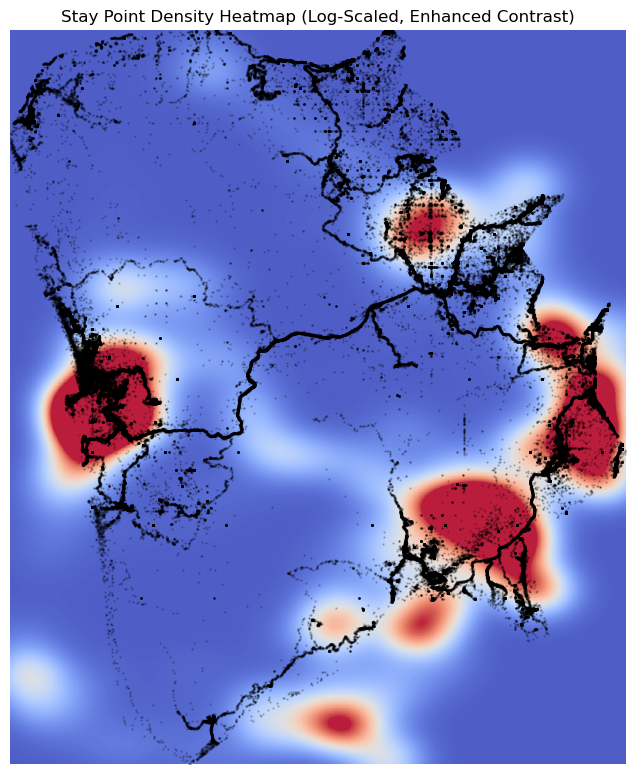

In [28]:
import matplotlib.pyplot as plt

import contextily as ctx

density_log = np.log1p(density)
vmax = np.percentile(density_log, 95)

plt.figure(figsize=(10, 8))
plt.imshow(
    np.rot90(density_log),
    cmap="coolwarm",
    extent=[xmin, xmax, ymin, ymax],
    origin='lower',
    vmin=0,
    vmax=vmax,
    alpha=0.9
)

ax = plt.gca()
# ctx.add_basemap(ax, crs=gdf_stay.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
# ctx.add_basemap(
#     ax,
#     crs=gdf_stay.crs.to_string(),
#     source=ctx.providers.CartoDB.PositronNoLabels,
#     alpha=0.2
# )

plt.axis("off")
plt.title("Stay Point Density Heatmap (Log-Scaled, Enhanced Contrast)")
plt.tight_layout()
plt.scatter(x, y, c='black', s=0.5, alpha=0.2)
plt.show()

